## Imports

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set_style("dark")
import pandas

## SOM implementation

In [10]:
def load_dataset(path):
    df = pandas.read_csv(path, delimiter=",")
    dataset = df.to_numpy()
    X = (dataset[:, 1:]+1)//2
    y = dataset[:, 0]

    return X, y

In [11]:
class SOM:
    def __init__(self, map_size, lr=0.1):
        """
        Args:
            map_size : [map_w, map_h, f=16]
        """
        self.map = np.random.random(size=(map_size[0], map_size[1], map_size[2]))
        # self.map = np.zeros(shape=(map_size[0], map_size[1], map_size[2]))

        self.lr0 = lr
        self.lr = self.lr0

        self.R0 = map_size[0] // 2
        self.R = self.R0

    def train(self, X, y, T=1000, error_threshold=10**-20):
        # Loss history
        Js = []
        for t in range(T):
            prev_map = self.map.copy()
            # Shuffle X in every iteration
            # shuffle_ind = np.arange(0, X.shape[0], 1)
            # np.random.shuffle(shuffle_ind)
            shuffle_ind = np.random.randint(0, X.shape[0], X.shape[0])
            for i in range(len(X)):
                x = X[shuffle_ind[i], :]
                # Neuron with most compatibilty with x
                winner = self.find_winner(x)
                # Get all neurons in the neighborhood of winner
                NS = self.get_NS(winner)
                # Update weights of all neurons in the neighborhood of winner
                self.update_weights(x, winner, NS, len(X)) 

            # Update learning rate and neighborhood radius (linear decay)
            self.lr = self.lr0 * (1 - t / T)
            self.R = self.R0 * (1 - t / T)


            Js.append(np.linalg.norm(prev_map - self.map))

            if t%10 == 0 or t == T-1:
                print(f"Iteration: {t}, Loss: {Js[-1]:.4f}, lr: {self.lr:.4f}, R: {self.R:.4f}")
                self.visualize(X, y)
            
            if Js[-1] < error_threshold:
                print("MIN CHANGE")
                break

        return Js
    
    def find_winner(self, x):
        rep_x = np.tile(x, (self.map.shape[0], self.map.shape[1], 1))
        dists = np.sum((self.map - rep_x) ** 2, axis=2)
        winner = np.unravel_index(np.argmin(dists, axis=None), shape=dists.shape)
        return winner

    def get_NS(self, winner):
        # NS: Neighborhood strength
        # if 1: winner
        # if 1/2: distance 1 from winner
        # if 1/3: distance 2 from winner
        # if 1/(1+r): distance r from winner
        # if 0: not neighbor
        NS = np.zeros((self.map.shape[0], self.map.shape[1]))

        # winner i,j
        iw, jw = winner[0], winner[1]
        
        NS[iw, jw] = 1 # Winner
        
        # Rectangular neighborhood (Change this for hexagonal or circular neighborhood)
        # for r in range(1, int(self.R)):
        #     if iw - r >=  0:
        #         NS[iw - r, jw] = 1/(1+r) # North
        #     if iw + r < self.map.shape[0]:
        #         NS[iw + r, jw] = 1/(1+r) # South
        #     if jw - r >= 0:
        #         NS[iw, jw - r] = 1/(1+r) # West
        #     if jw + r < self.map.shape[1]:
        #         NS[iw, jw + r] = 1/(1+r) # East

        for r in range(1, int(self.R)):
            if iw - r >=  0:
                NS[iw - r, jw] = 1/r # North
            if iw + r < self.map.shape[0]-1:
                NS[iw + r, jw] = 1/r # South
            if jw - r > 0:
                NS[iw, jw - r] = 1/r # West
            if jw + r < self.map.shape[1]-1:
                NS[iw, jw + r] = 1/r # East
        
        return NS

    def update_weights(self, x, winner, n_strength, X_len):
        # Note: n_map is already W*H we just need to make it W*H*f
        NS = np.tile(n_strength, (self.map.shape[2], 1, 1)).transpose()
        # another way:

        # Neigborhood strength
        # NS = np.repeat(n_strength[:, :, np.newaxis], self.map.shape[2], axis=2) # repeat f times in the last dimension

        # Difference between inputs and neurons
        rep_x = np.tile(x, (self.map.shape[0], self.map.shape[1], 1))
        Delta = rep_x - self.map

        # Update weights
        self.map = self.map + (self.lr/X_len) * np.multiply(NS, Delta)

    def visualize(self, X, y):
        self.scores = np.zeros(shape=(self.map.shape[0], self.map.shape[1], 3))

        for i in range(len(X)):
            x = X[i, :]
            winner = self.find_winner(x)
            iw, jw = winner[0], winner[1]
            if y[i] == 1: # Republican
                self.scores[iw, jw] += np.array([1, 0, 0])
            if y[i] == -1: # Democrat
                self.scores[iw, jw] += np.array([0, 0, 1])
            if y[i] == 0:
                self.scores[iw, jw] += np.array([0, 1, 0])

        plt.imshow(self.scores)
        plt.show()

## Main

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: 0, Loss: 0.0909, lr: 0.1000, R: 4.0000


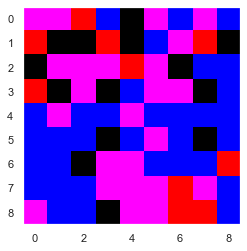

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: 10, Loss: 0.0722, lr: 0.0900, R: 3.6000


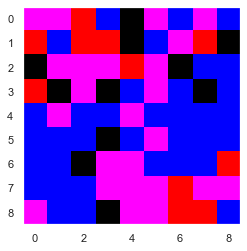

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: 20, Loss: 0.0569, lr: 0.0800, R: 3.2000


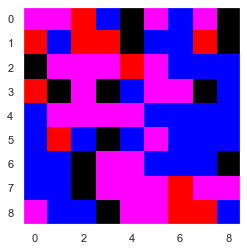

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: 30, Loss: 0.0409, lr: 0.0700, R: 2.8000


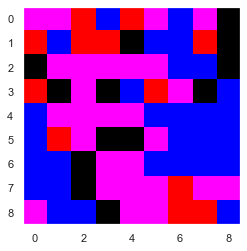

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: 40, Loss: 0.0340, lr: 0.0600, R: 2.4000


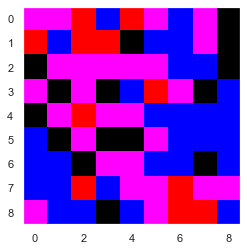

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: 50, Loss: 0.0282, lr: 0.0500, R: 2.0000


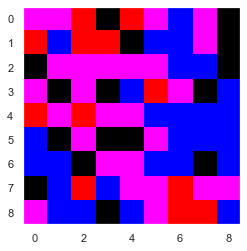

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: 60, Loss: 0.0133, lr: 0.0400, R: 1.6000


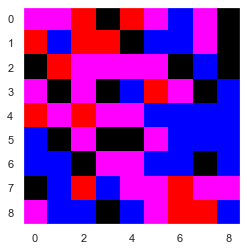

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: 70, Loss: 0.0104, lr: 0.0300, R: 1.2000


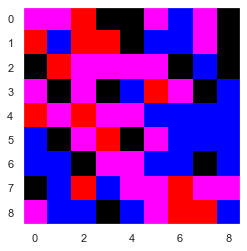

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: 80, Loss: 0.0065, lr: 0.0200, R: 0.8000


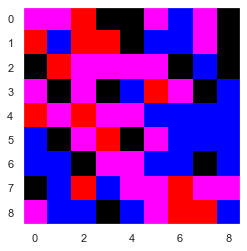

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: 90, Loss: 0.0035, lr: 0.0100, R: 0.4000


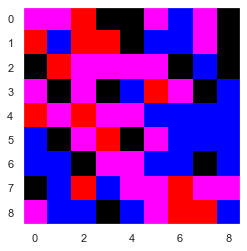

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: 99, Loss: 0.0006, lr: 0.0010, R: 0.0400


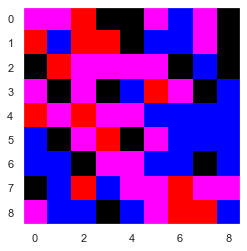

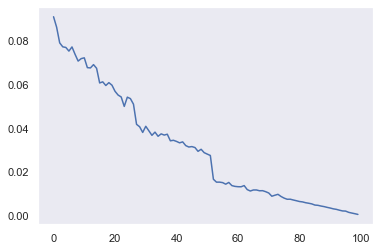

In [12]:
X, y = load_dataset("congress.csv")
som_net = SOM(map_size=(9,9,X.shape[1]))
Js = som_net.train(X, y, T=100)
plt.plot(Js)
plt.show()
# som_net.visualize(X, y)

## Tests

In [13]:
# unravel_index test
a = np.array([
    [6, 2, 3],
    [4, 5, 1]])
np.unravel_index(np.argmin(a, axis=None), shape=a.shape)

(1, 2)

In [14]:
# shuffle test
inds = np.arange(0, 1000, 1)
np.random.shuffle(inds)
inds[:20]

array([198, 797, 946,  42, 209, 763, 256, 874, 834, 983, 530,   1, 365,
       121, 566, 210, 926, 355, 574, 223])

In [15]:
# np.tile test
a = np.array([1, 2, 3])
res = np.tile(a, (2, 3, 1))
print(res.shape)
res

(2, 3, 3)


array([[[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]],

       [[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]]])

In [16]:
a = np.array([[1, 2], [1, 2]])
print(a.shape)

(2, 2)
